In [1]:
# assume you have openmm, pdbfixer and mdtraj installed.
# if not, you can follow the gudie here https://github.com/npschafer/openawsem

In [2]:
# import all using lines below

# from simtk.openmm.app import *
# from simtk.openmm import *
# from simtk.unit import *

In [3]:
from simtk.openmm.app import ForceField
# define atoms and residues.
forcefield = ForceField("cg.xml")

In [4]:
from pdbfixer import PDBFixer
from simtk.openmm.app import PDBFile

fixer = PDBFixer("1r69.pdb")
# more on pdbfixer, check:
# https://htmlpreview.github.io/?https://github.com/openmm/pdbfixer/blob/master/Manual.html
fixer.removeHeterogens(keepWater=False)
PDBFile.writeFile(fixer.topology, fixer.positions, open('1r69_cleaned.pdb', 'w'))

In [5]:
import mdtraj
pdb = mdtraj.load("1r69_cleaned.pdb")
keep_list = []
for atom in pdb.topology.atoms:
    if atom.name == "CA":
        keep_list.append(atom.index)
chosen = pdb.atom_slice(keep_list)
chosen.save("ca_only.pdb")

In [6]:
from simtk.openmm import HarmonicBondForce
def connect_term(system):
    k_con= 10000
    con = HarmonicBondForce()
    n = system.getNumParticles()
    for i in range(n-1):
        con.addBond(i, i+1, 0.3816, k_con)
    return con

from simtk.openmm import CustomBondForce
def connect_term_v2(system):
    k_con= 10000
    r0 = 0.3816
    con = CustomBondForce(f"0.5*{k_con}*(r-r0)^2")
    n = system.getNumParticles()
    con.addPerBondParameter("r0")
    for i in range(n-1):
        con.addBond(i, i+1, [r0])
    return con

from simtk.openmm import CustomCompoundBondForce
def connect_term_v3(system):
    k_con= 10000
    r0 = 0.3816
    con = CustomCompoundBondForce(2, f"0.5*{k_con}*(distance(p1,p2)-r0)^2")
    n = system.getNumParticles()
    con.addPerBondParameter("r0")
    for i in range(n-1):
        con.addBond([i, i+1], [r0])
    return con

In [7]:
# contact map
import numpy as np
from simtk.unit import *

pdb = PDBFile("ca_only.pdb")
pos = pdb.positions.value_in_unit(nanometer)
pos = np.array(pos)
dis = (((pos.reshape(1, -1, 3) - pos.reshape(-1, 1, 3))**2).sum(axis=-1))**0.5

In [8]:
import matplotlib.pylab as plt
%matplotlib inline

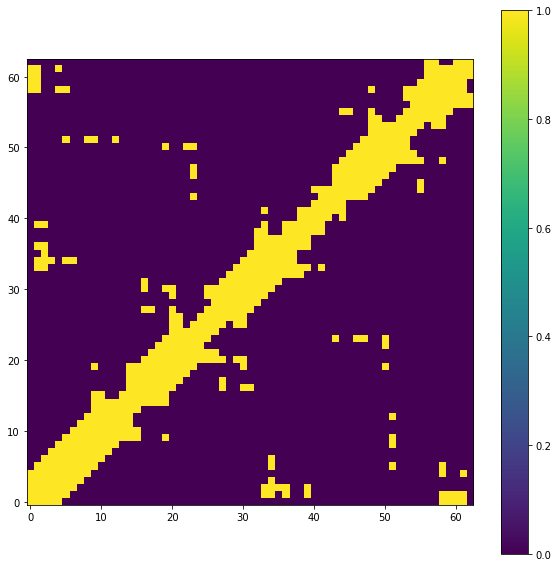

In [9]:
plt.figure(figsize=[10,10])
plt.imshow(dis < 0.8, origin="lower")
plt.colorbar()

In [10]:
n = dis.shape[0]
contact_threshold = 0.8 # in unit of nm
contact_list = []
for i in range(n):
    for j in range(i+1, n):
        dis_ij = dis[i][j]
        if dis_ij < contact_threshold:
            sigma_ij = 0.1*(j-i)**0.15
            contact_list.append((i, j, (dis_ij, sigma_ij)))

In [11]:
len(contact_list)

275

In [12]:
from simtk.openmm import CustomBondForce
def structure_based_term(contact_list):
    k = 10
    structure_based = CustomBondForce(f"-{k}*exp(-(r-r_ijN)^2/(2*sigma_ij^2))")
#     structure_based = CustomBondForce(f"-{k}")
    structure_based.addPerBondParameter("r_ijN")
    structure_based.addPerBondParameter("sigma_ij")
    for contact in contact_list:
        structure_based.addBond(*contact)
    return structure_based

In [13]:
from simtk.openmm import LangevinIntegrator
from simtk.openmm import CustomIntegrator
from simtk.openmm.app import Simulation
from simtk.openmm.app import PDBReporter
from simtk.openmm.app import StateDataReporter
from simtk.openmm.app import DCDReporter
from sys import stdout


pdb = PDBFile("ca_only.pdb")
forcefield = ForceField("cg.xml")

print(pdb.topology)

system = forcefield.createSystem(pdb.topology)
system.removeForce(0)   # remove the default force "CMotionRemover"
# connect = connect_term(system)
# system.addForce(connect)

# connect = connect_term_v2(system)
# system.addForce(connect)

connect = connect_term_v3(system)
system.addForce(connect)

structure_based = structure_based_term(contact_list)
system.addForce(structure_based)

print("Number of particles: ", system.getNumParticles())
print("Number of forces: ", system.getNumForces())

integrator = LangevinIntegrator(300*kelvin, 1/picosecond, 0.004*picoseconds)
simulation = Simulation(pdb.topology, system, integrator)
simulation.context.setPositions(pdb.positions)

<Topology; 1 chains, 63 residues, 63 atoms, 0 bonds>
Number of particles:  63
Number of forces:  2


In [14]:
simulation.reporters.append(PDBReporter('output.pdb', 1000))
simulation.reporters.append(StateDataReporter(stdout, 1000, step=True,
        potentialEnergy=True, temperature=True))
simulation.step(10000)

#"Step","Potential Energy (kJ/mole)","Temperature (K)"
1000,-2470.588134765625,265.3972095571674
2000,-2475.900390625,352.0954418361503
3000,-2447.06787109375,324.6016153903199
4000,-2443.67724609375,329.38365665470707
5000,-2472.291015625,311.95841512357555
6000,-2473.103759765625,354.3896434047219
7000,-2504.68701171875,232.2963285718921
8000,-2421.172607421875,318.1490746045123
9000,-2506.325439453125,311.90592414121977
10000,-2461.337890625,332.81687894573935


In [15]:
integrator = CustomIntegrator(0.001)
simulation = Simulation(pdb.topology, system, integrator)
simulation.context.setPositions(pdb.positions)
simulation.reporters.append(DCDReporter('output.dcd', 1))
simulation.reporters.append(StateDataReporter(stdout, 1, step=True,
        potentialEnergy=True, temperature=True))
simulation.step(int(1))
simulation.minimizeEnergy()
simulation.step(int(1))

integrator = LangevinIntegrator(300*kelvin, 1/picosecond, 0.004*picoseconds)
simulation = Simulation(pdb.topology, system, integrator)
simulation.context.setPositions(pdb.positions)
simulation.reporters.append(DCDReporter('output.dcd', 1000, append=True))
simulation.reporters.append(StateDataReporter(stdout, 1000, step=True,
        potentialEnergy=True, temperature=True))
simulation.step(10000)

#"Step","Potential Energy (kJ/mole)","Temperature (K)"
1,-2749.25732421875,0.0
2,-2749.87255859375,0.0
#"Step","Potential Energy (kJ/mole)","Temperature (K)"
1000,-2507.495361328125,304.4992072527908
2000,-2500.489501953125,312.70488546326226
3000,-2472.176513671875,292.76087883875005
4000,-2527.055419921875,314.59933267693776
5000,-2477.698486328125,298.6544357930838
6000,-2480.50732421875,247.62469027800051
7000,-2532.085205078125,341.49360963315706
8000,-2523.2939453125,335.394943970924
9000,-2519.30224609375,313.3308482276988
10000,-2456.395751953125,330.1487977186053


In [16]:
# conda install nglview -c conda-forge
# jupyter-nbextension enable nglview --py --sys-prefix
import nglview
view = nglview.show_pdbid("1r69")  # load "3pqr" from RCSB PDB and display viewer widget
view

NGLWidget()

In [17]:
view = nglview.show_structure_file("ca_only.pdb")
view

NGLWidget()

In [18]:
traj = mdtraj.load_dcd("output.dcd", top="ca_only.pdb")

In [19]:
view = nglview.show_mdtraj(traj)
view

NGLWidget(max_frame=11)

In [20]:
# Input: expects 3xN matrix of points
# Returns R,t
# R = 3x3 rotation matrix
# t = 3x1 column vector

def rigid_transform_3D(A, B, correct_reflection=True):
    assert A.shape == B.shape

    num_rows, num_cols = A.shape
    if num_rows != 3:
        raise Exception(f"matrix A is not 3xN, it is {num_rows}x{num_cols}")

    num_rows, num_cols = B.shape
    if num_rows != 3:
        raise Exception(f"matrix B is not 3xN, it is {num_rows}x{num_cols}")

    # find mean column wise
    centroid_A = np.mean(A, axis=1)
    centroid_B = np.mean(B, axis=1)

    # ensure centroids are 3x1
    centroid_A = centroid_A.reshape(-1, 1)
    centroid_B = centroid_B.reshape(-1, 1)

    # subtract mean
    Am = A - centroid_A
    Bm = B - centroid_B

    H = Am @ np.transpose(Bm)

    # sanity check
    #if linalg.matrix_rank(H) < 3:
    #    raise ValueError("rank of H = {}, expecting 3".format(linalg.matrix_rank(H)))

    # find rotation
    U, S, Vt = np.linalg.svd(H)
    R = Vt.T @ U.T

    # special reflection case
    if np.linalg.det(R) < 0 and correct_reflection:
        print("det(R) < R, reflection detected!, correcting for it ...")
        Vt[2,:] *= -1
        R = Vt.T @ U.T

    t = -R @ centroid_A + centroid_B

    return R, t

In [21]:
target = traj.xyz[0].T
n = traj.xyz.shape[0]
for i in range(1, n):
    current = traj.xyz[i].T
    ret_R, ret_t = rigid_transform_3D(current, target, correct_reflection=False)
    out = (ret_R@current) + ret_t
    traj.xyz[i] = out.T.reshape(1, -1, 3)

In [22]:
view = nglview.show_mdtraj(traj, gui=True)
view

NGLWidget(max_frame=11)

In [23]:
# energy evaluation.
pdb = PDBFile('ca_only.pdb')
traj = mdtraj.load_dcd("output.dcd", top='ca_only.pdb')

integrator = CustomIntegrator(0.001)
simulation = Simulation(pdb.topology, system, integrator)
for frame in range(traj.n_frames):
    simulation.context.setPositions(traj.openmm_positions(frame))
    state = simulation.context.getState(getEnergy=True)
    termEnergy = state.getPotentialEnergy().value_in_unit(kilojoule_per_mole)
#     termEnergy = state.getPotentialEnergy()
    print(frame, f"{termEnergy:.3f} kJ/mol")

0 -2749.257 kJ/mol
1 -2749.873 kJ/mol
2 -2507.495 kJ/mol
3 -2500.490 kJ/mol
4 -2472.177 kJ/mol
5 -2527.056 kJ/mol
6 -2477.699 kJ/mol
7 -2480.507 kJ/mol
8 -2532.085 kJ/mol
9 -2523.294 kJ/mol
10 -2519.302 kJ/mol
11 -2456.396 kJ/mol


In [24]:
system = forcefield.createSystem(pdb.topology)
system.removeForce(0)   # remove the default force "CMotionRemover"
connect = connect_term(system)
connect.setForceGroup(1)
system.addForce(connect)

connect = connect_term_v2(system)
connect.setForceGroup(2)
system.addForce(connect)

connect = connect_term_v3(system)
connect.setForceGroup(3)
system.addForce(connect)

structure_based = structure_based_term(contact_list)
structure_based.setForceGroup(4)
system.addForce(structure_based)

print("Number of particles: ", system.getNumParticles())
print("Number of forces: ", system.getNumForces())

integrator = LangevinIntegrator(300*kelvin, 1/picosecond, 0.004*picoseconds)
simulation = Simulation(pdb.topology, system, integrator)
simulation.context.setPositions(pdb.positions)

Number of particles:  63
Number of forces:  4


In [25]:
force_groups = {"con":1, "con_v2":2, "con_v3":3, "structure_based_term":4}
show_energy = ["con", "con_v2", "con_v3", "structure_based_term"]

In [26]:
integrator = CustomIntegrator(0.001)
simulation = Simulation(pdb.topology, system, integrator)
width = 15
line = "".join([f"{term:<15}" for term in ["frame"] + show_energy])
print(line)
for frame in range(traj.n_frames):
    simulation.context.setPositions(traj.openmm_positions(frame))
    all_energy = []
    for term in show_energy:
        group = force_groups[term]
        state = simulation.context.getState(getEnergy=True, groups={group})
        termEnergy = state.getPotentialEnergy().value_in_unit(kilojoule_per_mole)
        all_energy.append(termEnergy)
    line = "".join([f"{termEnergy:<15.3f}" for termEnergy in all_energy])
    print(f"{frame:<15}{line}")

frame          con            con_v2         con_v3         structure_based_term
0              0.743          0.743          0.743          -2750.000      
1              0.024          0.024          0.024          -2749.897      
2              72.760         72.760         72.760         -2580.256      
3              50.944         50.944         50.944         -2551.433      
4              56.587         56.587         56.587         -2528.763      
5              56.172         56.172         56.172         -2583.227      
6              72.370         72.370         72.370         -2550.069      
7              77.075         77.075         77.075         -2557.582      
8              54.391         54.391         54.391         -2586.476      
9              59.849         59.849         59.849         -2583.143      
10             70.668         70.668         70.668         -2589.970      
11             70.643         70.643         70.643         -2527.038      
